# Applied Data Science Capstone : The Battle of the Neighborhoods

Pierre-Antoine MAHE --- March 2020

## Table of contents

* [Introduction](#introduction)
* [Data](#data)
* [Neighborhood locations](#locations)
* [Getting Data From Foursquare](#foursquare)
* [Loading Data From Other Datasets](#otherdata)
* [Clustering](#clustering)
* [Recommender System](#recommender)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## 1. Introduction : <a name="introduction"></a>

This notebook presents the work performed to find the most appropriate living Neighborhood for a specific person.
More specifically, which neighborhoods in the city of **Rennes, Brittany, France** are optimals for this notebook author.

We will start by **extracting information** about all neighborhoods, **clusters** them based on them most popular venues and **identify** the more suitable ones.

## 2. Data <a name="data"></a>

The Neighborhoods location data is extracted from the **"perimetres-des-45-sous-quartiers-de-la-ville-de-rennes.geojson"** file, obtained from the **French Administration Open Data Website** :

'https://www.data.gouv.fr/fr/datasets/perimetres-des-45-sous-quartiers-de-la-ville-de-rennes/#_' 

and published under the Open Database Licence v1.0.

## 3. Neighborhood locations <a name="locations"></a>

We extract the Neighborhoods locations as well as a few more data points from the geojson file

In [1]:
# Data Wrangling Librairies
import json
import geopandas as gpd
import pandas as pd
import numpy as np

# Mapping Libraries
import folium
from geopy import geocoders
from geopy.geocoders import GoogleV3

# neeeded to get data from foursquare
import requests

# used to get area of geojson multipolygon
#!pip install area
import area

# Data visualization
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
fname = "./Data/sousQuartiers.geojson"

In [3]:
rennes_gdf = gpd.read_file(fname)
rennes_gdf.head()

nusquart  objectid  st_length_shape         nomsquart  st_area_shape  \
0       183         1              0.0  Sainte-Elisabeth   7.277667e+05   
1       110        34              0.0      Jeanne d'Arc   1.229057e+06   
2       100        38              0.0          Maurepas   8.089439e+05   
3       213        42              0.0     Saint-Laurent   5.709301e+05   
4       161        25              0.0   Moulin du Comte   8.192819e+05   

            gml_id  code_insee          nmsquart  nuquart  \
0   sousquartier.1       35238  SAINTE-ELISABETH       11   
1  sousquartier.34       35238      JEANNE D'ARC        6   
2  sousquartier.38       35238          MAUREPAS        5   
3  sousquartier.42       35238     SAINT-LAURENT        5   
4  sousquartier.25       35238   MOULIN DU COMTE        3   

                                            geometry  
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...  
1  POLYGON ((-1.65199 48.12709, -1.65194 48.12662...  
2  POLYGON ((-1.65649 48.13229, -1.65590 48.13230...  
3  POLYGON ((-1.65710 48.14297, -1.65719 48.14273...  
4  POLYGON ((-1.71133 48.11246, -1.71068 48.11244...

We are only interested in a few columns here :
    * objectid      -- the identification number of the neighborhood
    * st_area_shape -- the surface area of the neighborhood (in m²)
    * nmsquart      -- the name of the neighborhood (in capital letters to avoid encoding problems)
    * geometry      -- the polygon shape of the neighborhood

In [4]:
# Dropping useless columns
rennes_gdf.drop(['nusquart','st_length_shape','gml_id','code_insee','nuquart','nomsquart'], inplace=True, axis=1)
# Renaming columns
rennes_gdf.rename(columns={'objectid':'ID', 'nmsquart':'Name', 'st_area_shape':'Area'}, inplace=True)
rennes_gdf.head()

ID          Area              Name  \
0   1  7.277667e+05  SAINTE-ELISABETH   
1  34  1.229057e+06      JEANNE D'ARC   
2  38  8.089439e+05          MAUREPAS   
3  42  5.709301e+05     SAINT-LAURENT   
4  25  8.192819e+05   MOULIN DU COMTE   

                                            geometry  
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...  
1  POLYGON ((-1.65199 48.12709, -1.65194 48.12662...  
2  POLYGON ((-1.65649 48.13229, -1.65590 48.13230...  
3  POLYGON ((-1.65710 48.14297, -1.65719 48.14273...  
4  POLYGON ((-1.71133 48.11246, -1.71068 48.11244...

In order to extract information about popular venues using the Foursquare API, 
we will need to use the **neighborhood centroid latitude and longitude** values.

Those values are present in the geojson file as **property.geo_point_2d** but are not extracted by geopandas.read_file().
We will extract them manually

In [5]:
rennes_geojson = json.load(open(fname))

In [6]:
latitudes = []
longitudes = []
for k in rennes_geojson['features']:
    latitudes.append(k['properties']['geo_point_2d'][0])
    longitudes.append(k['properties']['geo_point_2d'][1])

In [7]:
rennes_gdf.loc[:,'Latitude'] = pd.Series(latitudes, index=rennes_gdf.index)
rennes_gdf.loc[:,'Longitude'] = pd.Series(longitudes, index=rennes_gdf.index)

In [8]:
rennes_gdf.head()

ID          Area              Name  \
0   1  7.277667e+05  SAINTE-ELISABETH   
1  34  1.229057e+06      JEANNE D'ARC   
2  38  8.089439e+05          MAUREPAS   
3  42  5.709301e+05     SAINT-LAURENT   
4  25  8.192819e+05   MOULIN DU COMTE   

                                            geometry   Latitude  Longitude  
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...  48.083447  -1.649838  
1  POLYGON ((-1.65199 48.12709, -1.65194 48.12662...  48.117866  -1.654097  
2  POLYGON ((-1.65649 48.13229, -1.65590 48.13230...  48.127741  -1.659100  
3  POLYGON ((-1.65710 48.14297, -1.65719 48.14273...  48.136749  -1.655807  
4  POLYGON ((-1.71133 48.11246, -1.71068 48.11244...  48.109302  -1.708775

Now we will just **reorder** the columns and **reindex** the dataframe based on the Neighborhood ID to facilitate future data selection.

In [9]:
# Moving rennes_gdf columns
fixed_columns = [rennes_gdf.columns[0], rennes_gdf.columns[2], rennes_gdf.columns[1], rennes_gdf.columns[-2], rennes_gdf.columns[-1], rennes_gdf.columns[-3]]
rennes_gdf = rennes_gdf[fixed_columns]

In [10]:
rennes_gdf.sort_values(by=['ID'], ascending=True, inplace=True)
rennes_gdf.reset_index(drop=True, inplace=True)
rennes_gdf.head()

ID              Name          Area   Latitude  Longitude  \
0   1  SAINTE-ELISABETH  7.277667e+05  48.083447  -1.649838   
1   2           TORIGNE  2.817688e+05  48.086334  -1.656086   
2   3        LE LANDREL  4.655899e+05  48.089569  -1.652624   
3   4         BREQUIGNY  1.258086e+06  48.084634  -1.691202   
4   5            ITALIE  1.214989e+06  48.083898  -1.667485   

                                            geometry  
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...  
1  POLYGON ((-1.66049 48.08825, -1.65922 48.08822...  
2  POLYGON ((-1.66125 48.09150, -1.66099 48.09148...  
3  POLYGON ((-1.69242 48.09027, -1.69152 48.09022...  
4  POLYGON ((-1.66431 48.09147, -1.66295 48.09149...

In [11]:
rennes_gdf.shape

(45, 6)

In [12]:
# Saving work
rennes_gdf.to_file("./Data/rennes_neighborhoods.geojson", driver="GeoJSON")

### First Visualization of Rennes Neighborhood

In [13]:
# Load Google api_key
with open("google_api.txt") as api_file:
    api_key = api_file.readline()
g = GoogleV3(api_key=api_key)

In [14]:
# Getting the location of Rennes
location = g.geocode('Rennes, France')
latitude = location.latitude
longitude = location.longitude

In [15]:
map_rennes = folium.Map(location=[latitude, longitude], tiles='OpenStreet Map', zoom_start=12, control_scale=True)

folium.GeoJson(rennes_gdf, name='geojson').add_to(map_rennes)

folium.LayerControl().add_to(map_rennes)

for lat, lng, name, number in zip(rennes_gdf['Latitude'], rennes_gdf['Longitude'], rennes_gdf['Name'], rennes_gdf['ID']):
    label = f"{number}.{name}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rennes)
    
map_rennes

## 4. Getting Data From Foursquare <a name="foursquare"></a>

### Explore Endpoint
We will start as we did in the course by using the explore endpoint in order to return recommended venues for each neighborhood.

In [16]:
# Loading Foursquare Credentials
with open("foursquare_api.txt") as ffile:
    CLIENT_ID = ffile.readline()
    CLIENT_SECRET = ffile.readline()

In [17]:
VERSION = "20190101"
LIMIT = 100
radius = 500

Here we will reuse the function from the course to **extract the categories** of returned venues.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        # we use day=any and time=any to mitigate the effect of the covid-19 lockdown
        # as well as recording interesting venues to live somewhere and not just visit at 8 PM
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&time=any&day=any'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url)
        results = results.json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [19]:
rennes_venues = getNearbyVenues(names=rennes_gdf['Name'],
                                latitudes=rennes_gdf['Latitude'],
                                longitudes=rennes_gdf['Longitude'])

SAINTE-ELISABETH
TORIGNE
LE LANDREL
BREQUIGNY
ITALIE
LA BINQUENAIS
LES CHALAIS
LES CHAMPS MANCEAUX
LA POTERIE
LA MADELEINE
FRANCISCO-FERRER - VERN
VILLENEUVE
SAINTE-THERESE - QUINELEU
LE LANDRY
CIMETIERE DE L'EST
Z.A. SUD-EST
LA PREVALAYE
CLEUNAY
COLOMBIER - CHAMP DE MARS
ALPHONSE GUERIN
SAINT-HELIER
ARSENAL - REDON
PLAINE DE BAUD
Z.A. OUEST
MOULIN DU COMTE
THABOR - PARIS
BOURG L'EVESQUE
CENTRE
ATALANTE-CHAMPEAUX
LA TOUCHE
DINAN - SAINT-MALO
FOUGERES - SEVIGNE
ATALANTE BEAULIEU
JEANNE D'ARC
VILLEJEAN
LES LONGS CHAMPS
LA MOTTE BRULON
MAUREPAS
NORD - SAINT-MARTIN
Z.A. NORD
BEAUREGARD
SAINT-LAURENT
LA BELLANGERAIS
LA LANDE DU BREIL
LES GAYEULLES


In [20]:
print(rennes_venues.shape)
print(len(rennes_venues['Neighborhood'].unique()))

rennes_venues

(382, 7)
43


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0            TORIGNE              48.086334               -1.656086   
1            TORIGNE              48.086334               -1.656086   
2            TORIGNE              48.086334               -1.656086   
3            TORIGNE              48.086334               -1.656086   
4            TORIGNE              48.086334               -1.656086   
..               ...                    ...                     ...   
377  LA BELLANGERAIS              48.135385               -1.667695   
378  LA BELLANGERAIS              48.135385               -1.667695   
379    LES GAYEULLES              48.140699               -1.639543   
380    LES GAYEULLES              48.140699               -1.639543   
381    LES GAYEULLES              48.140699               -1.639543   

                                      Venue  Venue Latitude  Venue Longitude  \
0                         Métro Le Blosne ⓐ       48.087712        -1.654290   
1                          Métro Triangle ⓐ       48.086451        -1.660330   
2               Centre culturel Le Triangle       48.088499        -1.659260   
3           Arrêt Triangle [32,33,61,161ex]       48.086173        -1.660973   
4                           Place De Prague       48.088210        -1.651891   
..                                      ...             ...              ...   
377                          Carrefour City       48.136480        -1.665130   
378                         square Josselin       48.136145        -1.668127   
379                             Redwings II       48.138497        -1.642880   
380  Leha Laboratoire D Analyse Sensorielle       48.138812        -1.635429   
381                               Le Garden       48.137729        -1.643389   

            Venue Category  
0            Metro Station  
1            Metro Station  
2    Performing Arts Venue  
3                 Bus Stop  
4                    Plaza  
..                     ...  
377            Supermarket  
378                  Plaza  
379         Baseball Field  
380            Wings Joint  
381   Gym / Fitness Center  

[382 rows x 7 columns]

We can see that the dataframe only has 44 unique values of 'Neighborhood'. This is because 'LA LANDE DU BREIL' Neighborhood doesn't have any recommended venue returned by Foursquare.

Anyway, around 40 venues divided by 45 Neighborhoods means an **average of 8.5 venues per Neighborhood**. It is not much and most of them are within the city center. Hence a discrepancy in the study of all Neighborhoods.

In [21]:
rennes_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
ALPHONSE GUERIN                               10                      10   
ARSENAL - REDON                                7                       7   
ATALANTE BEAULIEU                              6                       6   
ATALANTE-CHAMPEAUX                             3                       3   
BEAUREGARD                                     5                       5   
BOURG L'EVESQUE                                9                       9   
BREQUIGNY                                      4                       4   
CENTRE                                        57                      57   
CIMETIERE DE L'EST                             4                       4   
CLEUNAY                                        4                       4   
COLOMBIER - CHAMP DE MARS                     51                      51   
DINAN - SAINT-MALO                            22                      22   
FOUGERES - SEVIGNE                             8                       8   
FRANCISCO-FERRER - VERN                        5                       5   
ITALIE                                         5                       5   
JEANNE D'ARC                                   7                       7   
LA BELLANGERAIS                                2                       2   
LA BINQUENAIS                                  6                       6   
LA MADELEINE                                   7                       7   
LA MOTTE BRULON                                4                       4   
LA POTERIE                                     4                       4   
LA PREVALAYE                                   3                       3   
LA TOUCHE                                      5                       5   
LE LANDREL                                     4                       4   
LE LANDRY                                      3                       3   
LES CHALAIS                                   12                      12   
LES CHAMPS MANCEAUX                            5                       5   
LES GAYEULLES                                  3                       3   
LES LONGS CHAMPS                               4                       4   
MAUREPAS                                       6                       6   
MOULIN DU COMTE                                4                       4   
NORD - SAINT-MARTIN                            5                       5   
PLAINE DE BAUD                                 2                       2   
SAINT-HELIER                                  40                      40   
SAINT-LAURENT                                  3                       3   
SAINTE-THERESE - QUINELEU                      4                       4   
THABOR - PARIS                                 5                       5   
TORIGNE                                        8                       8   
VILLEJEAN                                      7                       7   
VILLENEUVE                                     5                       5   
Z.A. NORD                                     11                      11   
Z.A. OUEST                                     9                       9   
Z.A. SUD-EST                                   4                       4   

                           Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
ALPHONSE GUERIN               10              10               10   
ARSENAL - REDON                7               7                7   
ATALANTE BEAULIEU              6               6                6   
ATALANTE-CHAMPEAUX             3               3                3   
BEAUREGARD                     5               5                5   
BOURG L'EVESQUE                9               9                9   
BREQUIGNY                      4               4      

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

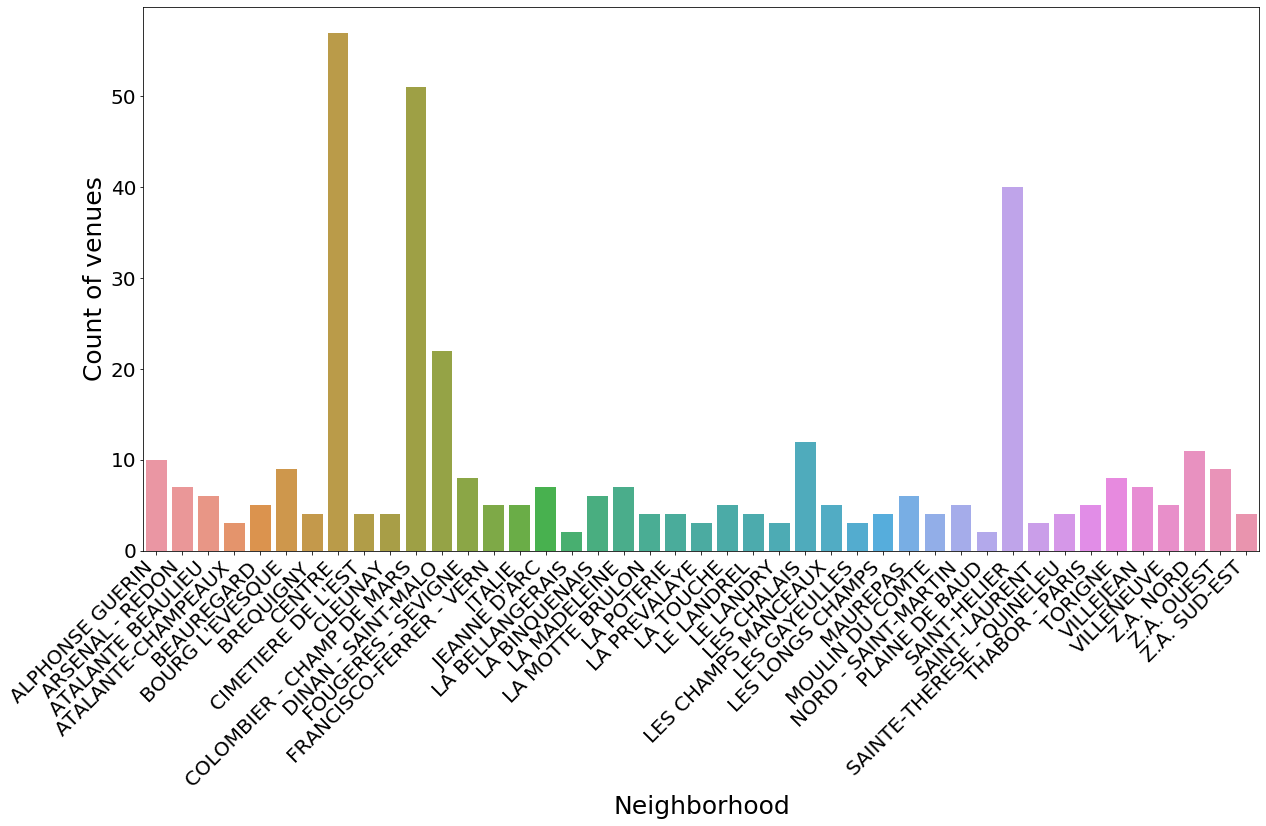

In [22]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.barplot

rennes_plot = rennes_venues.groupby('Neighborhood')['Venue'].count().transpose()

ax = sns.barplot(x = rennes_plot.index, y = rennes_plot)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Neighborhood', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

### Search Endpoint

To get more values to be returned by Foursquare we can try the search endpoint. It will return any venue in radius range around a given location. We need a slightly modified function to return venues categories :

In [23]:
def searchNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        temp = requests.get(url).json()
        results = temp['response']['venues']
        
        
        # return only relevant information for each nearby venue
        for i in range(len(results)):   
            try:
                venue_category = results[i]['categories'][0]['name']
            except:
                venue_category = ''
                
            #print(venue_name)    
            temp_list = [name, lat, lng, 
                         results[i]['name'], 
                         results[i]['location']['lat'],
                         results[i]['location']['lng'],
                         venue_category]
            
            venues_list.append([temp_list])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [24]:
rennes_search = searchNearbyVenues(names=rennes_gdf['Name'],
                                    latitudes=rennes_gdf['Latitude'],
                                    longitudes=rennes_gdf['Longitude'])

SAINTE-ELISABETH
TORIGNE
LE LANDREL
BREQUIGNY
ITALIE
LA BINQUENAIS
LES CHALAIS
LES CHAMPS MANCEAUX
LA POTERIE
LA MADELEINE
FRANCISCO-FERRER - VERN
VILLENEUVE
SAINTE-THERESE - QUINELEU
LE LANDRY
CIMETIERE DE L'EST
Z.A. SUD-EST
LA PREVALAYE
CLEUNAY
COLOMBIER - CHAMP DE MARS
ALPHONSE GUERIN
SAINT-HELIER
ARSENAL - REDON
PLAINE DE BAUD
Z.A. OUEST
MOULIN DU COMTE
THABOR - PARIS
BOURG L'EVESQUE
CENTRE
ATALANTE-CHAMPEAUX
LA TOUCHE
DINAN - SAINT-MALO
FOUGERES - SEVIGNE
ATALANTE BEAULIEU
JEANNE D'ARC
VILLEJEAN
LES LONGS CHAMPS
LA MOTTE BRULON
MAUREPAS
NORD - SAINT-MARTIN
Z.A. NORD
BEAUREGARD
SAINT-LAURENT
LA BELLANGERAIS
LA LANDE DU BREIL
LES GAYEULLES


In [25]:
print(rennes_search.shape)
rennes_search

(4422, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     SAINTE-ELISABETH              48.083447               -1.649838   
1     SAINTE-ELISABETH              48.083447               -1.649838   
2     SAINTE-ELISABETH              48.083447               -1.649838   
3     SAINTE-ELISABETH              48.083447               -1.649838   
4     SAINTE-ELISABETH              48.083447               -1.649838   
...                ...                    ...                     ...   
4417     LES GAYEULLES              48.140699               -1.639543   
4418     LES GAYEULLES              48.140699               -1.639543   
4419     LES GAYEULLES              48.140699               -1.639543   
4420     LES GAYEULLES              48.140699               -1.639543   
4421     LES GAYEULLES              48.140699               -1.639543   

                               Venue  Venue Latitude  Venue Longitude  \
0        Arrêt Sainte-Elisabeth [59]       48.084894        -1.650996   
1                      Relais H Café       48.083519        -1.653464   
2                        Hôpital Sud       48.083661        -1.654323   
3                 Le Plaisir Du Gout       48.085090        -1.650835   
4                     Taste Pleasure       48.084860        -1.650442   
...                              ...             ...              ...   
4417        AIMT Médecine du travail       48.130657        -1.634645   
4418             Longchamps Coiffure       48.130731        -1.633522   
4419  Complexe sportif des Gayeulles       48.133071        -1.650386   
4420                            G111       48.137402        -1.650140   
4421            La casa de Guillermo       48.129714        -1.641871   

                                Venue Category  
0                                     Bus Stop  
1                                    Bookstore  
2                                     Hospital  
3                                       Bakery  
4                                       Bakery  
...                                        ...  
4417                           Doctor's Office  
4418                        Salon / Barbershop  
4419                              Tennis Court  
4420                         College Classroom  
4421  Residential Building (Apartment / Condo)  

[4422 rows x 7 columns]

In [26]:
rennes_search.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
ALPHONSE GUERIN                              100                     100   
ARSENAL - REDON                              100                     100   
ATALANTE BEAULIEU                            100                     100   
ATALANTE-CHAMPEAUX                           100                     100   
BEAUREGARD                                   100                     100   
BOURG L'EVESQUE                              100                     100   
BREQUIGNY                                    100                     100   
CENTRE                                       100                     100   
CIMETIERE DE L'EST                           100                     100   
CLEUNAY                                      100                     100   
COLOMBIER - CHAMP DE MARS                    100                     100   
DINAN - SAINT-MALO                            97                      97   
FOUGERES - SEVIGNE                           100                     100   
FRANCISCO-FERRER - VERN                      100                     100   
ITALIE                                       100                     100   
JEANNE D'ARC                                 100                     100   
LA BELLANGERAIS                              100                     100   
LA BINQUENAIS                                100                     100   
LA LANDE DU BREIL                            100                     100   
LA MADELEINE                                 100                     100   
LA MOTTE BRULON                              100                     100   
LA POTERIE                                   100                     100   
LA PREVALAYE                                 100                     100   
LA TOUCHE                                    100                     100   
LE LANDREL                                   100                     100   
LE LANDRY                                    100                     100   
LES CHALAIS                                  100                     100   
LES CHAMPS MANCEAUX                          100                     100   
LES GAYEULLES                                100                     100   
LES LONGS CHAMPS                             100                     100   
MAUREPAS                                     100                     100   
MOULIN DU COMTE                              100                     100   
NORD - SAINT-MARTIN                          100                     100   
PLAINE DE BAUD                               100                     100   
SAINT-HELIER                                  39                      39   
SAINT-LAURENT                                100                     100   
SAINTE-ELISABETH                              89                      89   
SAINTE-THERESE - QUINELEU                     97                      97   
THABOR - PARIS                               100                     100   
TORIGNE                                      100                     100   
VILLEJEAN                                    100                     100   
VILLENEUVE                                   100                     100   
Z.A. NORD                                    100                     100   
Z.A. OUEST                                   100                     100   
Z.A. SUD-EST                                 100                     100   

                           Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
ALPHONSE GUERIN              100             100              100   
ARSENAL - REDON              100             100              100   
ATALANTE BEAULIEU            100             100              100   
ATALANTE-CHAMPEAUX           100             100              100   
BEAUREGARD                   100        

This time we get around 4400 venues and most of them have 100 venues listed (coherent with LIMIT=100 defined above).
This is much better but ...

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

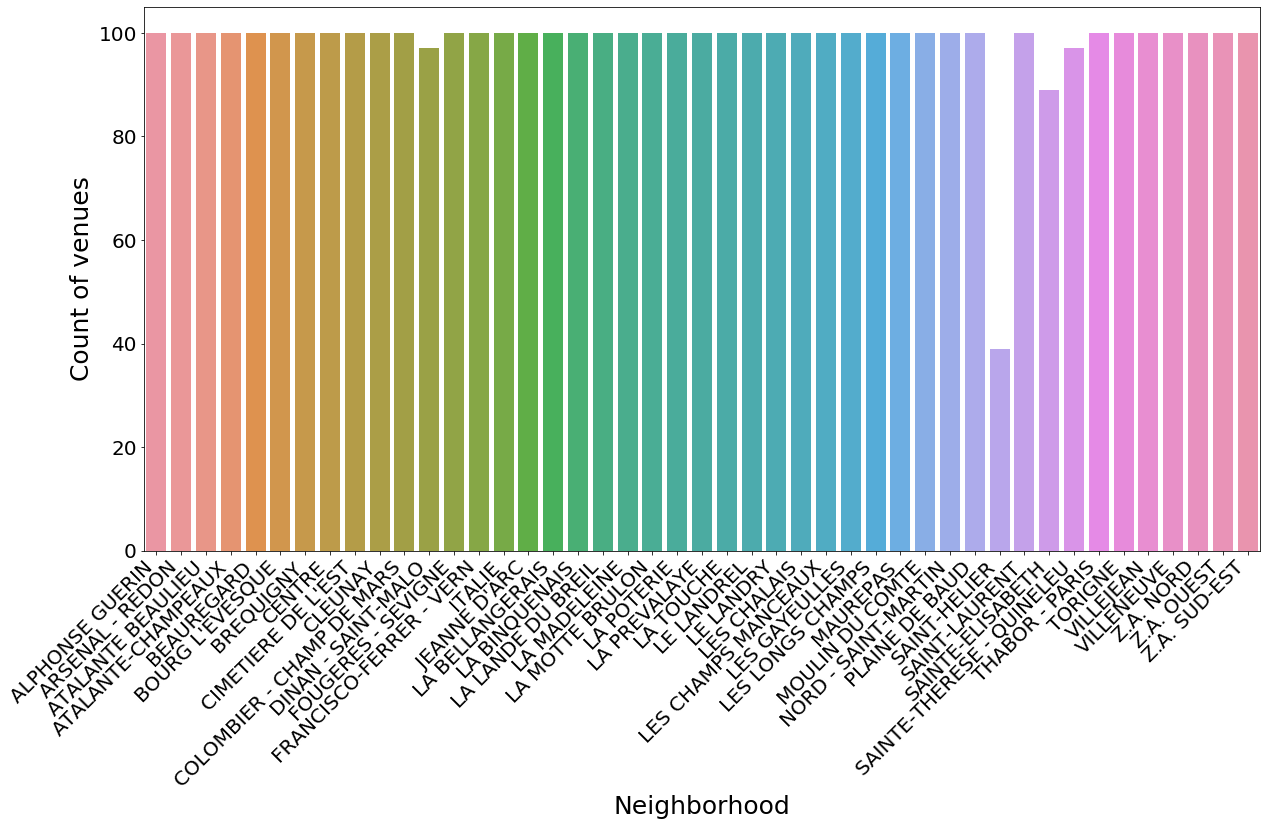

In [27]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.barplot

rennes_plot_search = rennes_search.groupby('Neighborhood')['Venue'].count().transpose()

ax = sns.barplot(x = rennes_plot_search.index, y = rennes_plot_search)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Neighborhood', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

In [28]:
rennes_search['Venue Category'].unique()

array(['Bus Stop', 'Bookstore', 'Hospital', 'Bakery', 'Fire Station',
       'Supermarket', 'College Residence Hall', '', 'Big Box Store',
       "Dentist's Office", 'Market', 'Parking', 'Shopping Mall',
       'Metro Station', 'Football Stadium', 'Performing Arts Venue',
       'Thrift / Vintage Store', 'Outdoors & Recreation',
       "Doctor's Office", 'Medical Center', 'Park', 'Road', 'Playground',
       'Library', 'Fast Food Restaurant', 'Hookah Bar',
       'Housing Development', 'Plaza', 'Pharmacy', 'Other Great Outdoors',
       'Garden', 'Pizza Place', 'Speakeasy', 'Office',
       'Residential Building (Apartment / Condo)', 'High School',
       'Basketball Court', 'Bridge', 'Squash Court', 'College Rec Center',
       'Nightclub', 'Coworking Space', 'Police Station', 'Student Center',
       'Skate Park', 'Soccer Field', 'Club House', 'Spa', 'Field',
       'School', 'Café', 'Farmers Market', 'Building', 'Comedy Club',
       'Automotive Shop', 'Bank', 'Miscellaneous Shop',


We can see there is a **lot of different categories**. That is the downside of the search endpoint, 
those venues are not recommended so it will output pretty much **everything and anything** like 'Residential Building',
'Bus stops' and even the 'Hospital'.

Even more all restaurants, Bars etc. may be listed in a **sub-category that is not really relevant for us**.
For example If you want a lively area to live in, restaurants may be a good indicator. But you don't need
to know that you have 3 Italians, 2 Greeks and so on.

This is why we are gonna use the **categories endpoint**, to regroup all the venues that have the same meaning to us.

### Category Endpoint

This endpoint return a list of categories used by Foursquare. We will limit ourselves to the 10 top-level categories :

In [29]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()
len(results['response']['categories'])

10

Let's start by storing those categories and their IDs

In [30]:
categories_list = []

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


Now that we have a list of categories, we can go back to the search endpoint to regroup what we previously found.
Only this time we wont limit the result to 100.

In [31]:
def get_venues_count(latitude, longitude, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude,
                longitude,
                radius,
                categoryId)
    
    return len(requests.get(explore_url).json()['response']['venues'])

In [32]:
result = {}
for index, row in rennes_gdf.iterrows():
    print(index, end=' ')
    for c in categories_list:
        temp = get_venues_count(row['Latitude'], row['Longitude'], radius=1000, categoryId=c[1])
        result[row['Name'] + '_' + c[0]] = temp
        
print('\n')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 



In [33]:
# Let's not pollute our original dataframe with all this data
rennes_categories = rennes_gdf.copy()

# Now we can extract useful data from the result dict created above
all_categories = []

for i in range(0, 450, 10):
    all_categories.append([result[k] for k in result.keys()][i:i+10])

counter=0
for c in categories_list:
    temp = [k[counter] for k in all_categories]
    rennes_categories[c[0]] = temp 
    counter+=1

rennes_categories.head()

ID              Name          Area   Latitude  Longitude  \
0   1  SAINTE-ELISABETH  7.277667e+05  48.083447  -1.649838   
1   2           TORIGNE  2.817688e+05  48.086334  -1.656086   
2   3        LE LANDREL  4.655899e+05  48.089569  -1.652624   
3   4         BREQUIGNY  1.258086e+06  48.084634  -1.691202   
4   5            ITALIE  1.214989e+06  48.083898  -1.667485   

                                            geometry  Arts & Entertainment  \
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...                     2   
1  POLYGON ((-1.66049 48.08825, -1.65922 48.08822...                     3   
2  POLYGON ((-1.66125 48.09150, -1.66099 48.09148...                     3   
3  POLYGON ((-1.69242 48.09027, -1.69152 48.09022...                    10   
4  POLYGON ((-1.66431 48.09147, -1.66295 48.09149...                     5   

   College & University  Event  Food  Nightlife Spot  Outdoors & Recreation  \
0                     3      0     6               3                     15   
1                     3      0    11               2                     22   
2                     4      0    14               3                     20   
3                     1      0    27               1                      9   
4                     2      0    17               1                     14   

   Professional & Other Places  Residence  Shop & Service  Travel & Transport  
0                           20          7               9                  11  
1                           19          7              17                  14  
2                           19          9              16                  16  
3                           23          5              24                   7  
4                           26          5              20                   7

Before going any further toward the clustering work, we can try to use the other dataset that we found.

## 5. Loading Data From Other Datasets <a name="otherdata"></a>

As for the Neighborhoods location, those datasets are extracted from  the French Administration Open Data Website :

https://www.data.gouv.fr/

and published under the Open Database Licence v1.0.

In order to not overload this notebook (already kind of long) with excessive data wrangling, the other datasets are studied in their
respective notebook :
    
    - playground_and_greenspaces : 
   https://github.com/pamahe/AppliedDataScienceCapstone/blob/master/Datasets/playground_and_greenspaces.ipynb
    
    - cultural_equipments : 
    
https://github.com/pamahe/AppliedDataScienceCapstone/blob/master/Datasets/cultural_equipments.ipynb
    
    - grasslands :

https://github.com/pamahe/AppliedDataScienceCapstone/blob/master/Datasets/green_spaces.ipynb

### Loading playground_and_greenspaces.json

In [34]:
pgs_gdf = gpd.read_file("./Data/cleaned_data/playground_and_greenspaces.geojson")
pgs_gdf.head()

Object_ID Water Lighting           Object_Name Public_Space  \
0          2                    JARDIN DU BONHEUR          OUI   
1          3                 PROMENADE DES DOMBES          OUI   
2          4                  SQUARE DE LA MARCHE          OUI   
3          5                        ALLEE DE BRNO          OUI   
4          6                   JARDIN ARC EN CIEL          OUI   

   Neighborhood_ID   Latitude  Longitude  \
0               11  48.125615  -1.659514   
1               13  48.123342  -1.707076   
2               18  48.122309  -1.714101   
3               11  48.127573  -1.661070   
4               11  48.127121  -1.658643   

                                            geometry  
0  MULTIPOLYGON (((-1.65895 48.12563, -1.65904 48...  
1  MULTIPOLYGON (((-1.70714 48.12337, -1.70713 48...  
2  MULTIPOLYGON (((-1.71404 48.12236, -1.71399 48...  
3  MULTIPOLYGON (((-1.66103 48.12754, -1.66110 48...  
4  MULTIPOLYGON (((-1.65856 48.12700, -1.65860 48...

### Loading cultural_equipments.geojson

In [35]:
ce_gdf = gpd.read_file("./Data/cleaned_data/cultural_equipments.geojson")
ce_gdf.head()

Venue Category  Borough_ID  \
0                          Community leisure centers           2   
1                          Community leisure centers           5   
2  Wednesday and small-vacations municipal recrea...           8   
3                                Municipal libraries           4   
4                                Municipal libraries           6   

           Audiences                                              Hours  \
0  Childs, Teenagers  Lundi, mardi et jeudi, 14h à 18h. Mercredi, 9h...   
1  Childs, Teenagers  Lundi, mardi, jeudi et vendredi : 10h à 12h30 ...   
2  Childs, Teenagers                                   De 12h15 à 18h45   
3      All Audiences  Mardi et jeudi, 16h30 à 18h30. Mercredi, 10h à...   
4      All Audiences  Mardi et vendredi, 14h30 à 18h30. Mercredi, 10...   

        Latitude      Longitude                   geometry  
0    48.11199639   -1.667547278  POINT (-1.66755 48.11200)  
1    48.13198222   -1.654075436  POINT (-1.65408 48.13198)  
2  48.1017143864  -1.6668462590  POINT (-1.66685 48.10171)  
3      48.122952   -1.685703696  POINT (-1.68570 48.12295)  
4    48.12804386   -1.635549791  POINT (-1.63555 48.12804)

### Loading grasslands.geojson

In [36]:
grass_gdf = gpd.read_file("./Data/cleaned_data/grasslands.geojson")
grass_gdf.head()

Name  Neighborhood_ID Type of Surface   Latitude  \
0  MAIL LOUISE BOURGEOIS               19           Grass  48.102762   
1    CHEMIN DES LOUVRIES               14          Meadow  48.146857   
2    CHEMIN DES LOUVRIES               14          Meadow  48.146189   
3  MAIL LOUISE BOURGEOIS               19      Wet Meadow  48.102745   
4  MAIL LOUISE BOURGEOIS               19           Grass  48.102661   

   Longitude                                           geometry  
0  -1.662893  MULTIPOLYGON (((-1.66297 48.10281, -1.66295 48...  
1  -1.630007  MULTIPOLYGON (((-1.62954 48.14565, -1.62954 48...  
2  -1.630393  MULTIPOLYGON (((-1.63062 48.14727, -1.63063 48...  
3  -1.663677  MULTIPOLYGON (((-1.66363 48.10279, -1.66367 48...  
4  -1.663064  MULTIPOLYGON (((-1.66313 48.10266, -1.66300 48...

Unfortunately those datasets cannot be used as is. To avoid any bias I would need to check if any of their items is already present in the data returned by Foursquare and I don't have the time right now.

## 6. Clustering <a name="clustering"></a>


### First Visualization of categories

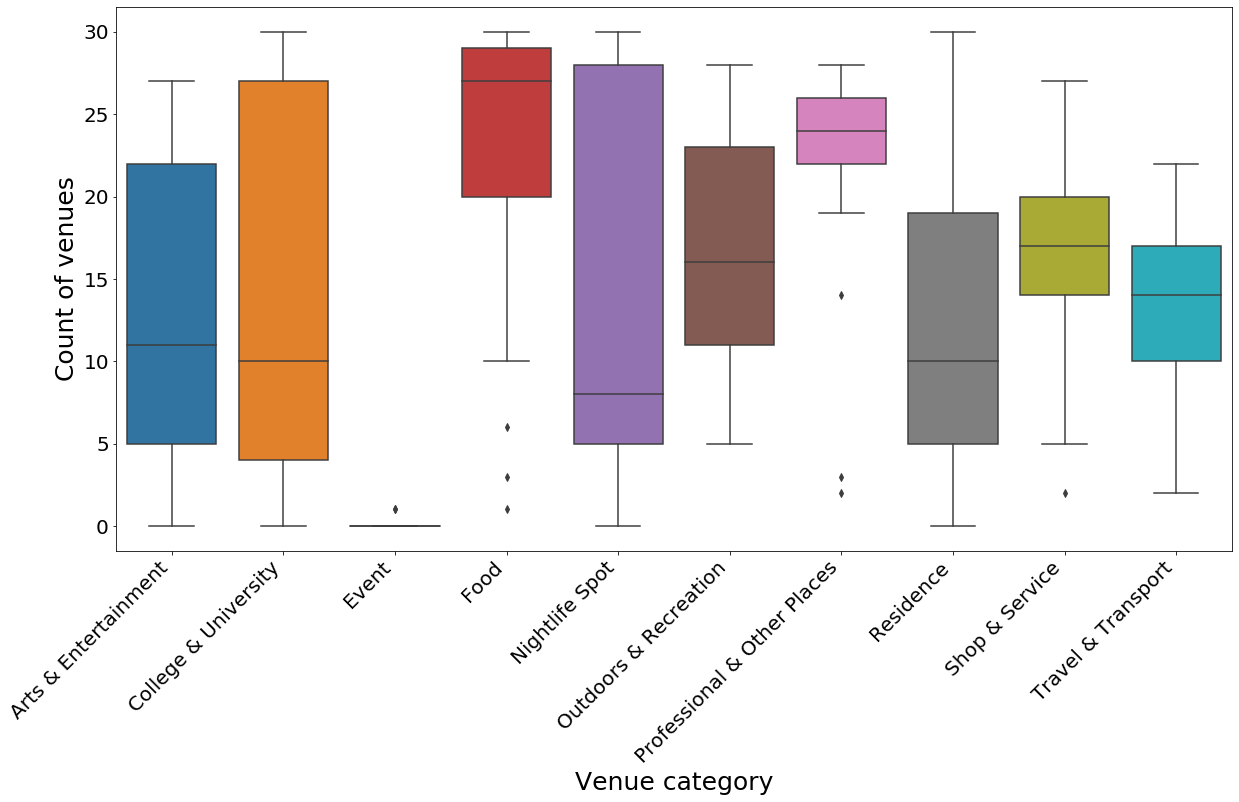

In [37]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = rennes_categories.iloc[:,6:])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

We can see that the 'Event' category is almost non-existant. We will start by removing it from the dataframe as well as from the catefories_list

In [38]:
rennes_categories.drop('Event', axis=1, inplace=True)
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

### Normalization

Normalization with MinMaxScaler improve readability between clusters as all categories are now defined from 0 to 1.
The closer to 1, the more present they are in the Neighborhood.

In [39]:
categories = rennes_categories.values[:,6:]
cluster_df = MinMaxScaler().fit_transform(categories)

In [40]:
cluster_df = pd.DataFrame(cluster_df)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.074074              0.100000  0.172414        0.100000   
1              0.111111              0.100000  0.344828        0.066667   
2              0.111111              0.133333  0.448276        0.100000   
3              0.370370              0.033333  0.896552        0.033333   
4              0.185185              0.066667  0.551724        0.033333   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0               0.434783                     0.692308   0.233333   
1               0.739130                     0.653846   0.233333   
2               0.652174                     0.653846   0.300000   
3               0.173913                     0.807692   0.166667   
4               0.391304                     0.923077   0.166667   

   Shop & Service  Travel & Transport  
0            0.28                0.45  
1            0.60                0.60  
2            0.56                0.70  
3            0.88                0.25  
4            0.72                0.25

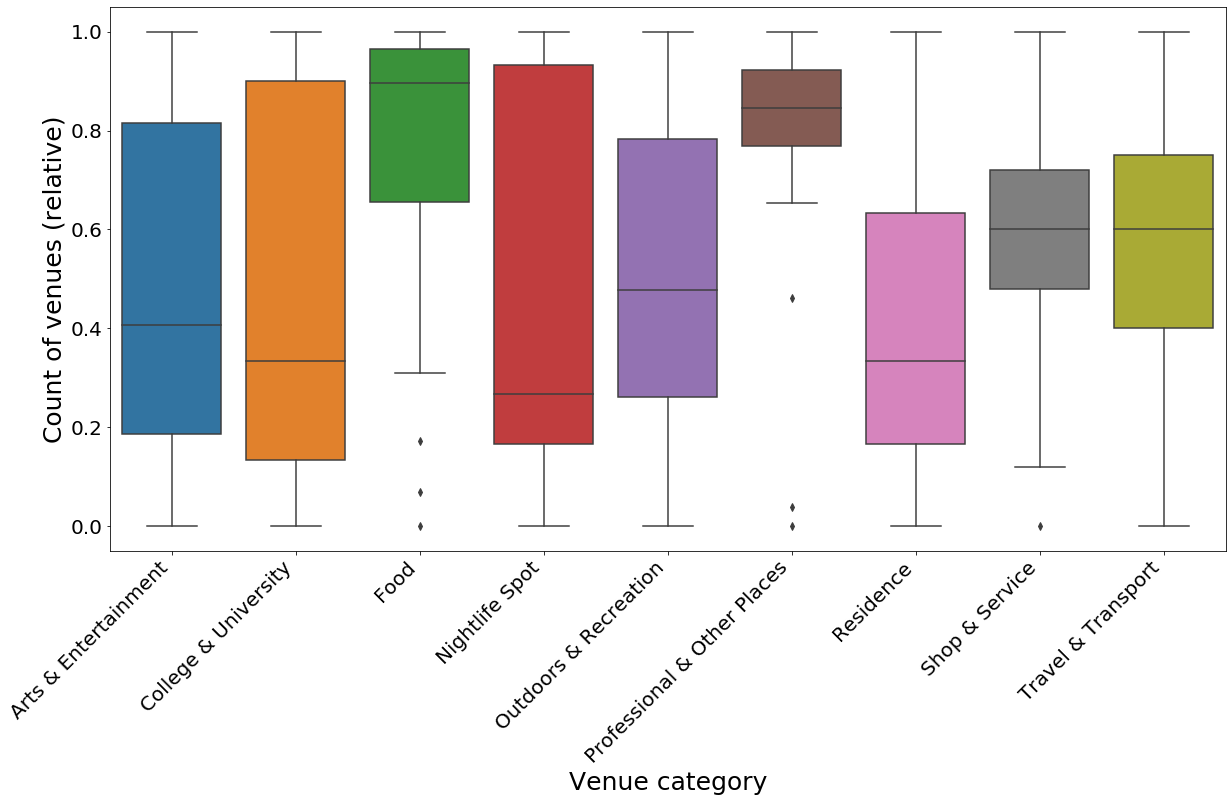

In [41]:
plt.figure(figsize=(20,10))
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

We can see that, even  with the search endpoint, the 'Food' and 'Shop' categories are still highly represented. 
Even if the professional is also pretty high, the low variation seems to show that it is confined to a small number of neighborhoods.

Clustering will show that so let's get to it.

### Clustering

Tests not presented here (see presentation : ) showed that the best number of clusters is kclusters = 5.
 
 * 2 Clusters only separate te city center and less dense areas
 * 3 Clusters does a better job but variation is still pretty high
 * 4 Clusters is still not enough
 * 5 Clusters allows for a good separation of neighborhoods with low number of venues
 * 6 Clusters makes it hard to extract insight

In [42]:
# number of clusters
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_

print(kmeans_labels[0])

2


In [43]:
# Change label numbers so they go from highest scores to lowest
print(kmeans_labels)

[2 2 2 0 2 0 0 0 0 0 0 1 1 0 0 0 3 0 1 1 1 1 4 0 1 1 1 1 0 1 1 1 4 4 4 4 4
 0 1 0 4 2 2 3 2]


In [72]:
replace_labels = {0:3, 1:0, 2:4, 3:2, 4:1}

for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]
print(kmeans_labels)

[3 3 3 2 3 2 2 2 2 2 2 0 0 2 2 2 4 2 0 0 0 0 1 2 0 0 0 0 2 0 0 0 1 1 1 1 1
 2 0 2 1 3 3 4 3]


In [73]:
rennes_categories['Cluster'] = kmeans_labels
cluster_df['Cluster'] = kmeans_labels

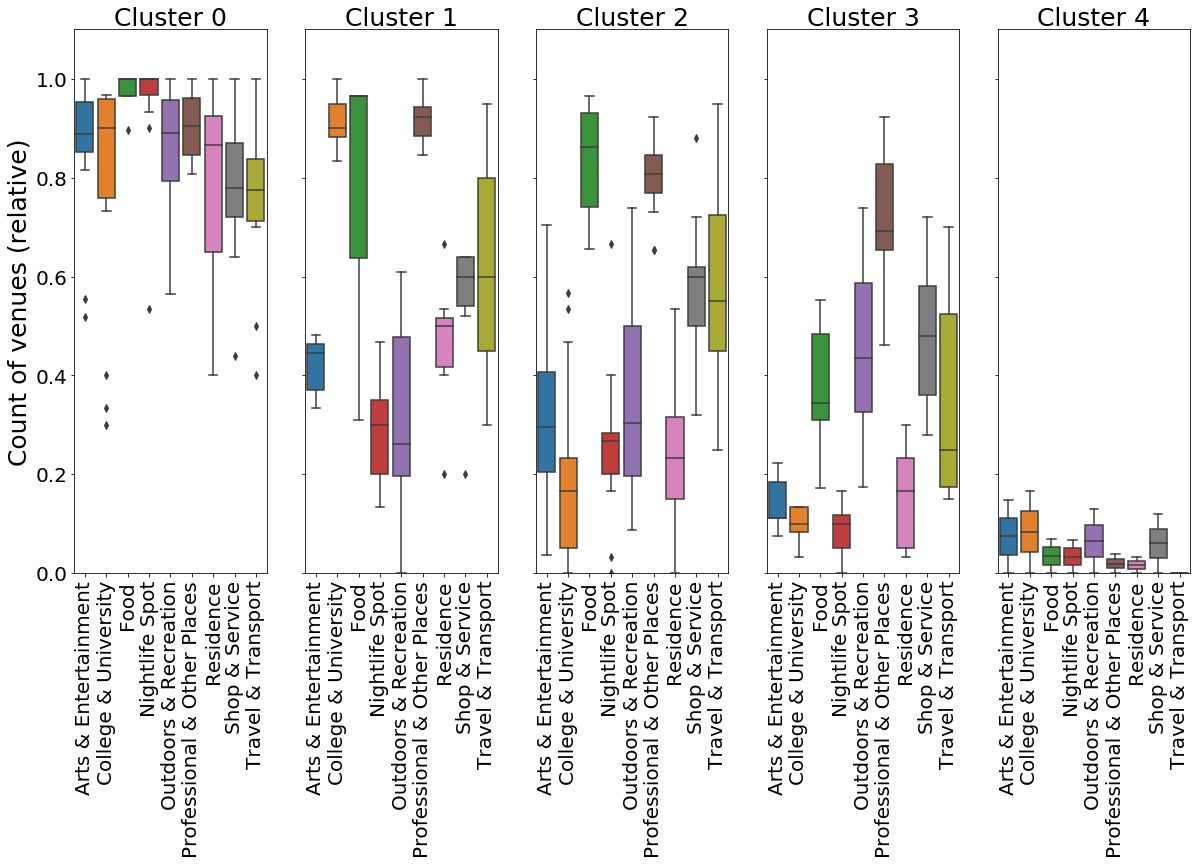

In [74]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)
axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k_ in range(kclusters):
    #Set same y axis limits
    axes[k_].set_ylim(0,1.1)
    axes[k_].xaxis.set_label_position('top')
    axes[k_].set_xlabel('Cluster ' + str(k_), fontsize=25)
    axes[k_].tick_params(labelsize=20)
    plt.sca(axes[k_])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = cluster_df[cluster_df['Cluster'] == k_].drop('Cluster',1), ax=axes[k_])

plt.show()

And we can now map the clustered Neighborhoods.

In [47]:
# Let's try to plot the Neighborhoods with colors matching their clusters
# first go back to old dataframe
rennes_gdf['Cluster'] = kmeans_labels

# We define 6 different colors. Just in case we need 6 Clusters
colors = {
    '0':'#EF161E',
    '1':'#2DBE2C',
    '2':'#0078BE',
    '3':'#00BFFF',
    '4':'#8D5B2D',
}

cluster_color = []
rennes_gdf['Color'] = 0
for index, row in rennes_gdf.iterrows():
    cluster_color.append(colors[str(row['Cluster']).strip()])
    
rennes_gdf['Color'] = cluster_color

In [48]:
rennes_gdf.head()

ID              Name          Area   Latitude  Longitude  \
0   1  SAINTE-ELISABETH  7.277667e+05  48.083447  -1.649838   
1   2           TORIGNE  2.817688e+05  48.086334  -1.656086   
2   3        LE LANDREL  4.655899e+05  48.089569  -1.652624   
3   4         BREQUIGNY  1.258086e+06  48.084634  -1.691202   
4   5            ITALIE  1.214989e+06  48.083898  -1.667485   

                                            geometry  Cluster    Color  
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...        0  #EF161E  
1  POLYGON ((-1.66049 48.08825, -1.65922 48.08822...        0  #EF161E  
2  POLYGON ((-1.66125 48.09150, -1.66099 48.09148...        0  #EF161E  
3  POLYGON ((-1.69242 48.09027, -1.69152 48.09022...        3  #00BFFF  
4  POLYGON ((-1.66431 48.09147, -1.66295 48.09149...        0  #EF161E

In [49]:
map_rennes = folium.Map(location=[latitude, longitude], tiles='OpenStreet Map', zoom_start=12, control_scale=True)


style_function=lambda feature: {
    'fillColor': feature['properties']['Color'],
    'color' : feature['properties']['Color'],
    'weight' : 1,
    'fillOpacity' : 0.5,
     }

folium.GeoJson(rennes_gdf, name='geojson', style_function=style_function).add_to(map_rennes)

folium.LayerControl().add_to(map_rennes)

for lat, lng, name, number, color in zip(rennes_gdf['Latitude'], rennes_gdf['Longitude'], rennes_gdf['Name'], rennes_gdf['ID'], rennes_gdf['Color']):
    label = f"{number}.{name}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_rennes)
    
map_rennes

## 7. Recommender System <a name="recommender"></a>

Now that all clusters are defined, we already have the data ready to be use in a recommender system. All venues categories are noted from 0 to 1. We only need to build 'users profiles'.

In [50]:
for i in range(len(categories_list)):
    print(categories_list[i])

('Arts & Entertainment', '4d4b7104d754a06370d81259')
('College & University', '4d4b7105d754a06372d81259')
('Food', '4d4b7105d754a06374d81259')
('Nightlife Spot', '4d4b7105d754a06376d81259')
('Outdoors & Recreation', '4d4b7105d754a06377d81259')
('Professional & Other Places', '4d4b7105d754a06375d81259')
('Residence', '4e67e38e036454776db1fb3a')
('Shop & Service', '4d4b7105d754a06378d81259')
('Travel & Transport', '4d4b7105d754a06379d81259')


Our user profiles are quite categorical, a lot of categories have a user rating of 0.9 or 0.01. This is done to artifically separate clusters and neighborhoods so results are visually different for each user.

In [51]:
# Let's define "typical" user profile
user_profiles = {
    'student' : [0.01, 0.9, 0.01, 0.9, 0.9, 0.01, 0.01, 0.1, 0.01],
    'family' : [0.1, 0.01, 0.9, 0.01, 0.9, 0.1, 0.1, 0.9, 0.1],
    'young_adult' : [0.9, 0.01, 0.9, 0.9, 0.9, 0.9, 0.01, 0.01, 0.01]
    }

user_df = pd.DataFrame(user_profiles)
user_df

student  family  young_adult
0     0.01    0.10         0.90
1     0.90    0.01         0.01
2     0.01    0.90         0.90
3     0.90    0.01         0.90
4     0.90    0.90         0.90
5     0.01    0.10         0.90
6     0.01    0.10         0.01
7     0.10    0.90         0.01
8     0.01    0.10         0.01

#### Content based recommender system

Obvioulsy we don't have past user data, so a content based recommender is the way to go.

Let's start by creating a Neighborhoods matrix :

In [52]:
recommended_df = cluster_df.copy()
recommended_df.drop(['Cluster'], axis=1, inplace=True)
recommended_df.head()

Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.074074              0.100000  0.172414        0.100000   
1              0.111111              0.100000  0.344828        0.066667   
2              0.111111              0.133333  0.448276        0.100000   
3              0.370370              0.033333  0.896552        0.033333   
4              0.185185              0.066667  0.551724        0.033333   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0               0.434783                     0.692308   0.233333   
1               0.739130                     0.653846   0.233333   
2               0.652174                     0.653846   0.300000   
3               0.173913                     0.807692   0.166667   
4               0.391304                     0.923077   0.166667   

   Shop & Service  Travel & Transport  
0            0.28                0.45  
1            0.60                0.60  
2            0.56                0.70  
3            0.88                0.25  
4            0.72                0.25

In [53]:
# Create ratings for every user, the closer to 1, the more attractive the Neighborhood is.
final_ratings = {}
for key, value in user_profiles.items():
    
    rating = (recommended_df * np.asarray(value).T).sum(axis=1)/sum(value)
    final_ratings[key] = rating

In [54]:
final_ratings

{'student': 0     0.215974
 1     0.313912
 2     0.307049
 3     0.115591
 4     0.187698
 5     0.279897
 6     0.139954
 7     0.179126
 8     0.373379
 9     0.378489
 10    0.418920
 11    0.650399
 12    0.649113
 13    0.311039
 14    0.360906
 15    0.170584
 16    0.046162
 17    0.204109
 18    0.947675
 19    0.790156
 20    0.916585
 21    0.744820
 22    0.473191
 23    0.150573
 24    0.739305
 25    0.936956
 26    0.888166
 27    0.948863
 28    0.402658
 29    0.974044
 30    0.945893
 31    0.963906
 32    0.342685
 33    0.616386
 34    0.614983
 35    0.440772
 36    0.606190
 37    0.458643
 38    0.976655
 39    0.320653
 40    0.470515
 41    0.273323
 42    0.161840
 43    0.073936
 44    0.113932
 dtype: float64, 'family': 0     0.303028
 1     0.537519
 2     0.536293
 3     0.613961
 4     0.528916
 5     0.564874
 6     0.554847
 7     0.546516
 8     0.635367
 9     0.599698
 10    0.644923
 11    0.742634
 12    0.794133
 13    0.559196
 14    0.541249
 15

In [55]:
def get_scores(user_rating):

    df = rennes_gdf.copy()
    df['rating'] = user_rating
    return df

In [56]:
student_rating = get_scores(final_ratings['student'])
student_rating.head()

ID              Name          Area   Latitude  Longitude  \
0   1  SAINTE-ELISABETH  7.277667e+05  48.083447  -1.649838   
1   2           TORIGNE  2.817688e+05  48.086334  -1.656086   
2   3        LE LANDREL  4.655899e+05  48.089569  -1.652624   
3   4         BREQUIGNY  1.258086e+06  48.084634  -1.691202   
4   5            ITALIE  1.214989e+06  48.083898  -1.667485   

                                            geometry  Cluster    Color  \
0  POLYGON ((-1.65024 48.08759, -1.64920 48.08757...        0  #EF161E   
1  POLYGON ((-1.66049 48.08825, -1.65922 48.08822...        0  #EF161E   
2  POLYGON ((-1.66125 48.09150, -1.66099 48.09148...        0  #EF161E   
3  POLYGON ((-1.69242 48.09027, -1.69152 48.09022...        3  #00BFFF   
4  POLYGON ((-1.66431 48.09147, -1.66295 48.09149...        0  #EF161E   

     rating  
0  0.215974  
1  0.313912  
2  0.307049  
3  0.115591  
4  0.187698

In [57]:
student_rating.sort_values('rating',ascending=False, inplace=True)
student_rating.head()

ID                       Name          Area   Latitude  Longitude  \
38  39        NORD - SAINT-MARTIN  1.311349e+06  48.125031  -1.682606   
29  30                  LA TOUCHE  2.959681e+05  48.116258  -1.691863   
31  32         FOUGERES - SEVIGNE  1.027480e+06  48.118852  -1.668569   
27  28                     CENTRE  6.771564e+05  48.111549  -1.679164   
18  19  COLOMBIER - CHAMP DE MARS  4.763455e+05  48.105099  -1.679341   

                                             geometry  Cluster    Color  \
38  POLYGON ((-1.69374 48.13381, -1.69365 48.13375...        1  #2DBE2C   
29  POLYGON ((-1.69044 48.11903, -1.68959 48.11882...        1  #2DBE2C   
31  POLYGON ((-1.66585 48.12397, -1.66558 48.12378...        1  #2DBE2C   
27  POLYGON ((-1.67772 48.11726, -1.67756 48.11723...        1  #2DBE2C   
18  POLYGON ((-1.68455 48.10857, -1.68402 48.10858...        1  #2DBE2C   

      rating  
38  0.976655  
29  0.974044  
31  0.963906  
27  0.948863  
18  0.947675

In [58]:
student_rating.loc[(student_rating['rating'] > 0.8)]

ID                       Name          Area   Latitude  Longitude  \
38  39        NORD - SAINT-MARTIN  1.311349e+06  48.125031  -1.682606   
29  30                  LA TOUCHE  2.959681e+05  48.116258  -1.691863   
31  32         FOUGERES - SEVIGNE  1.027480e+06  48.118852  -1.668569   
27  28                     CENTRE  6.771564e+05  48.111549  -1.679164   
18  19  COLOMBIER - CHAMP DE MARS  4.763455e+05  48.105099  -1.679341   
30  31         DINAN - SAINT-MALO  4.692513e+05  48.116532  -1.682934   
25  26             THABOR - PARIS  8.007038e+05  48.112478  -1.665398   
20  21               SAINT-HELIER  4.972003e+05  48.106508  -1.669161   
26  27            BOURG L'EVESQUE  6.931813e+05  48.111238  -1.693335   

                                             geometry  Cluster    Color  \
38  POLYGON ((-1.69374 48.13381, -1.69365 48.13375...        1  #2DBE2C   
29  POLYGON ((-1.69044 48.11903, -1.68959 48.11882...        1  #2DBE2C   
31  POLYGON ((-1.66585 48.12397, -1.66558 48.12378...        1  #2DBE2C   
27  POLYGON ((-1.67772 48.11726, -1.67756 48.11723...        1  #2DBE2C   
18  POLYGON ((-1.68455 48.10857, -1.68402 48.10858...        1  #2DBE2C   
30  POLYGON ((-1.68237 48.12098, -1.68182 48.12061...        1  #2DBE2C   
25  POLYGON ((-1.67051 48.11548, -1.67034 48.11548...        1  #2DBE2C   
20  POLYGON ((-1.67395 48.10988, -1.67284 48.10988...        1  #2DBE2C   
26  POLYGON ((-1.69422 48.11419, -1.69379 48.11413...        1  #2DBE2C   

      rating  
38  0.976655  
29  0.974044  
31  0.963906  
27  0.948863  
18  0.947675  
30  0.945893  
25  0.936956  
20  0.916585  
26  0.888166

We can see that Cluster 4's Neighborhood are the most appropriate for the student lifestyle. 

Another thing to note is that, in a cluster, not all neighborhoods have the same rating. For example, in Cluster 1, 3 neighborhoods have a rating slightly superior to 0.5 when another one is below 0.4

We can plot those result quickly to help visualize :

In [59]:
ratings_map = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale=True)

# the opacity can show the rating pretty well 
# you may need to zoom in to differentiate close ratings
style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue',
    'weight' : 1,
    # the round function is used for an increased contrast
    'fillOpacity' : round(feature['properties']['rating'],1),
     }

folium.GeoJson(student_rating, name='geojson', style_function=style_function).add_to(ratings_map)

folium.LayerControl().add_to(ratings_map)

for lat, lng, name, number, color, cluster, rating in zip(student_rating['Latitude'], student_rating['Longitude'], student_rating['Name'], student_rating['ID'], student_rating['Color'], student_rating['Cluster'], student_rating['rating']):
    label = f"{number}.{name} :: Cluster : {cluster} :: Rating : {round(rating,2)}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ratings_map)

ratings_map

Let's do the same for the 'family' and 'young_adult' profiles.

In [60]:
family_rating = get_scores(final_ratings['family'])

family_rating.sort_values('rating',ascending=False, inplace=True)


ratings_map = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale=True)

# the opacity can show the rating pretty well 
# you may need to zoom in to differentiate close ratings
style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue',
    'weight' : 1,
    # the round function is used for an increased contrast
    'fillOpacity' : round(feature['properties']['rating'],1),
     }

folium.GeoJson(family_rating, name='geojson', style_function=style_function).add_to(ratings_map)

folium.LayerControl().add_to(ratings_map)

for lat, lng, name, number, color, cluster, rating in zip(family_rating['Latitude'], family_rating['Longitude'], family_rating['Name'], family_rating['ID'], family_rating['Color'], family_rating['Cluster'], family_rating['rating']):
    label = f"{number}.{name} :: Cluster : {cluster} :: Rating : {round(rating,2)}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ratings_map)

ratings_map

In [61]:
adult_rating = get_scores(final_ratings['young_adult'])

adult_rating.sort_values('rating',ascending=False, inplace=True)


ratings_map = folium.Map(location=[latitude, longitude], zoom_start=12, control_scale=True)

# the opacity can show the rating pretty well 
# you may need to zoom in to differentiate close ratings
style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue',
    'weight' : 1,
    # the round function is used for an increased contrast
    'fillOpacity' : round(feature['properties']['rating'],1),
     }

folium.GeoJson(adult_rating, name='geojson', style_function=style_function).add_to(ratings_map)

folium.LayerControl().add_to(ratings_map)

for lat, lng, name, number, color, cluster, rating in zip(adult_rating['Latitude'], adult_rating['Longitude'], adult_rating['Name'], adult_rating['ID'], adult_rating['Color'], adult_rating['Cluster'], adult_rating['rating']):
    label = f"{number}.{name} :: Cluster : {cluster} :: Rating : {round(rating,2)}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ratings_map)

ratings_map

There is actually not much differences in the map. let's try to understand why

In [62]:
student_rating.loc[(student_rating['rating'] > 0.8)]

ID                       Name          Area   Latitude  Longitude  \
38  39        NORD - SAINT-MARTIN  1.311349e+06  48.125031  -1.682606   
29  30                  LA TOUCHE  2.959681e+05  48.116258  -1.691863   
31  32         FOUGERES - SEVIGNE  1.027480e+06  48.118852  -1.668569   
27  28                     CENTRE  6.771564e+05  48.111549  -1.679164   
18  19  COLOMBIER - CHAMP DE MARS  4.763455e+05  48.105099  -1.679341   
30  31         DINAN - SAINT-MALO  4.692513e+05  48.116532  -1.682934   
25  26             THABOR - PARIS  8.007038e+05  48.112478  -1.665398   
20  21               SAINT-HELIER  4.972003e+05  48.106508  -1.669161   
26  27            BOURG L'EVESQUE  6.931813e+05  48.111238  -1.693335   

                                             geometry  Cluster    Color  \
38  POLYGON ((-1.69374 48.13381, -1.69365 48.13375...        1  #2DBE2C   
29  POLYGON ((-1.69044 48.11903, -1.68959 48.11882...        1  #2DBE2C   
31  POLYGON ((-1.66585 48.12397, -1.66558 48.12378...        1  #2DBE2C   
27  POLYGON ((-1.67772 48.11726, -1.67756 48.11723...        1  #2DBE2C   
18  POLYGON ((-1.68455 48.10857, -1.68402 48.10858...        1  #2DBE2C   
30  POLYGON ((-1.68237 48.12098, -1.68182 48.12061...        1  #2DBE2C   
25  POLYGON ((-1.67051 48.11548, -1.67034 48.11548...        1  #2DBE2C   
20  POLYGON ((-1.67395 48.10988, -1.67284 48.10988...        1  #2DBE2C   
26  POLYGON ((-1.69422 48.11419, -1.69379 48.11413...        1  #2DBE2C   

      rating  
38  0.976655  
29  0.974044  
31  0.963906  
27  0.948863  
18  0.947675  
30  0.945893  
25  0.936956  
20  0.916585  
26  0.888166

In [63]:
family_rating.loc[(family_rating['rating'] > 0.8)]

ID                       Name          Area   Latitude  Longitude  \
29  30                  LA TOUCHE  2.959681e+05  48.116258  -1.691863   
27  28                     CENTRE  6.771564e+05  48.111549  -1.679164   
21  22            ARSENAL - REDON  7.924247e+05  48.104941  -1.691248   
18  19  COLOMBIER - CHAMP DE MARS  4.763455e+05  48.105099  -1.679341   
30  31         DINAN - SAINT-MALO  4.692513e+05  48.116532  -1.682934   
26  27            BOURG L'EVESQUE  6.931813e+05  48.111238  -1.693335   
38  39        NORD - SAINT-MARTIN  1.311349e+06  48.125031  -1.682606   
31  32         FOUGERES - SEVIGNE  1.027480e+06  48.118852  -1.668569   
20  21               SAINT-HELIER  4.972003e+05  48.106508  -1.669161   
25  26             THABOR - PARIS  8.007038e+05  48.112478  -1.665398   
24  25            MOULIN DU COMTE  8.192819e+05  48.109302  -1.708775   

                                             geometry  Cluster    Color  \
29  POLYGON ((-1.69044 48.11903, -1.68959 48.11882...        1  #2DBE2C   
27  POLYGON ((-1.67772 48.11726, -1.67756 48.11723...        1  #2DBE2C   
21  POLYGON ((-1.68458 48.10934, -1.68455 48.10862...        1  #2DBE2C   
18  POLYGON ((-1.68455 48.10857, -1.68402 48.10858...        1  #2DBE2C   
30  POLYGON ((-1.68237 48.12098, -1.68182 48.12061...        1  #2DBE2C   
26  POLYGON ((-1.69422 48.11419, -1.69379 48.11413...        1  #2DBE2C   
38  POLYGON ((-1.69374 48.13381, -1.69365 48.13375...        1  #2DBE2C   
31  POLYGON ((-1.66585 48.12397, -1.66558 48.12378...        1  #2DBE2C   
20  POLYGON ((-1.67395 48.10988, -1.67284 48.10988...        1  #2DBE2C   
25  POLYGON ((-1.67051 48.11548, -1.67034 48.11548...        1  #2DBE2C   
24  POLYGON ((-1.71133 48.11246, -1.71068 48.11244...        1  #2DBE2C   

      rating  
29  0.971828  
27  0.937743  
21  0.929880  
18  0.928177  
30  0.913182  
26  0.912744  
38  0.891771  
31  0.886909  
20  0.877922  
25  0.844660  
24  0.815967

In [64]:
adult_rating.loc[(adult_rating['rating'] > 0.8)]

ID                       Name          Area   Latitude  Longitude  \
30  31         DINAN - SAINT-MALO  4.692513e+05  48.116532  -1.682934   
27  28                     CENTRE  6.771564e+05  48.111549  -1.679164   
29  30                  LA TOUCHE  2.959681e+05  48.116258  -1.691863   
18  19  COLOMBIER - CHAMP DE MARS  4.763455e+05  48.105099  -1.679341   
21  22            ARSENAL - REDON  7.924247e+05  48.104941  -1.691248   
38  39        NORD - SAINT-MARTIN  1.311349e+06  48.125031  -1.682606   
26  27            BOURG L'EVESQUE  6.931813e+05  48.111238  -1.693335   
25  26             THABOR - PARIS  8.007038e+05  48.112478  -1.665398   
31  32         FOUGERES - SEVIGNE  1.027480e+06  48.118852  -1.668569   
20  21               SAINT-HELIER  4.972003e+05  48.106508  -1.669161   
12  13  SAINTE-THERESE - QUINELEU  1.256637e+06  48.098102  -1.667952   
11  12                 VILLENEUVE  6.135391e+05  48.097872  -1.679870   

                                             geometry  Cluster    Color  \
30  POLYGON ((-1.68237 48.12098, -1.68182 48.12061...        1  #2DBE2C   
27  POLYGON ((-1.67772 48.11726, -1.67756 48.11723...        1  #2DBE2C   
29  POLYGON ((-1.69044 48.11903, -1.68959 48.11882...        1  #2DBE2C   
18  POLYGON ((-1.68455 48.10857, -1.68402 48.10858...        1  #2DBE2C   
21  POLYGON ((-1.68458 48.10934, -1.68455 48.10862...        1  #2DBE2C   
38  POLYGON ((-1.69374 48.13381, -1.69365 48.13375...        1  #2DBE2C   
26  POLYGON ((-1.69422 48.11419, -1.69379 48.11413...        1  #2DBE2C   
25  POLYGON ((-1.67051 48.11548, -1.67034 48.11548...        1  #2DBE2C   
31  POLYGON ((-1.66585 48.12397, -1.66558 48.12378...        1  #2DBE2C   
20  POLYGON ((-1.67395 48.10988, -1.67284 48.10988...        1  #2DBE2C   
12  POLYGON ((-1.66380 48.10424, -1.66378 48.10423...        1  #2DBE2C   
11  POLYGON ((-1.67660 48.10252, -1.67656 48.10239...        1  #2DBE2C   

      rating  
30  0.975081  
27  0.968099  
29  0.960640  
18  0.960607  
21  0.941134  
38  0.937949  
26  0.933895  
25  0.923492  
31  0.921893  
20  0.920535  
12  0.900666  
11  0.853549

Let's map only the neighborhoods with a rating above 0.8 so that difference between close ratings can be more visible

In [65]:
student_test = student_rating.loc[(student_rating['rating'] > 0.8)].copy()
student_test['rank'] = np.arange(1, len(student_test['rating'])+1)

In [66]:
ratings_map = folium.Map(location=[latitude, longitude], zoom_start=13, control_scale=True)

# the opacity can show the rating pretty well 
# you may need to zoom in to differentiate close ratings
style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue',
    'weight' : 1,
    # the round function is used for an increased contrast
    'fillOpacity' : feature['properties']['rank'] / 10,
     }

folium.GeoJson(student_test, name='geojson', style_function=style_function).add_to(ratings_map)

folium.LayerControl().add_to(ratings_map)

for lat, lng, name, number, color, cluster, rating in zip(student_test['Latitude'], student_test['Longitude'], student_test['Name'], student_test['ID'], student_test['Color'], student_test['Cluster'], student_test['rating']):
    label = f"{number}.{name} :: Cluster : {cluster} :: Rating : {round(rating,2)}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ratings_map)

ratings_map

In [67]:
family_test = family_rating.loc[(family_rating['rating'] > 0.8)].copy()
family_test['rank'] = np.arange(1, len(family_test['rating'])+1)

ratings_map = folium.Map(location=[latitude, longitude], zoom_start=13, control_scale=True)

# the opacity can show the rating pretty well 
# you may need to zoom in to differentiate close ratings
style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue',
    'weight' : 1,
    # the round function is used for an increased contrast
    'fillOpacity' : feature['properties']['rank'] / 10,
     }

folium.GeoJson(family_test, name='geojson', style_function=style_function).add_to(ratings_map)

folium.LayerControl().add_to(ratings_map)

for lat, lng, name, number, color, cluster, rating in zip(family_test['Latitude'], family_test['Longitude'], family_test['Name'], family_test['ID'], family_test['Color'], family_test['Cluster'], family_test['rating']):
    label = f"{number}.{name} :: Cluster : {cluster} :: Rating : {round(rating,2)}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ratings_map)

ratings_map

In [68]:
adult_test = adult_rating.loc[(adult_rating['rating'] > 0.8)].copy()
adult_test['rank'] = np.arange(1, len(adult_test['rating'])+1)

In [69]:
all_results = student_test.copy()

In [70]:
all_results.drop(['Area', 'Latitude', 'Longitude', 'geometry', 'Color', 'rating'], axis=1, inplace=True)
all_results.rename(columns={'rank':'student_rank'})

ID                       Name  Cluster  student_rank
38  39        NORD - SAINT-MARTIN        1             1
29  30                  LA TOUCHE        1             2
31  32         FOUGERES - SEVIGNE        1             3
27  28                     CENTRE        1             4
18  19  COLOMBIER - CHAMP DE MARS        1             5
30  31         DINAN - SAINT-MALO        1             6
25  26             THABOR - PARIS        1             7
20  21               SAINT-HELIER        1             8
26  27            BOURG L'EVESQUE        1             9

In [71]:
all_results['family_rank'] = family_test['rank']
all_results['adult_rank'] = adult_test['rank']
all_results

ID                       Name  Cluster  rank  family_rank  adult_rank
38  39        NORD - SAINT-MARTIN        1     1            7           6
29  30                  LA TOUCHE        1     2            1           3
31  32         FOUGERES - SEVIGNE        1     3            8           9
27  28                     CENTRE        1     4            2           2
18  19  COLOMBIER - CHAMP DE MARS        1     5            4           4
30  31         DINAN - SAINT-MALO        1     6            5           1
25  26             THABOR - PARIS        1     7           10           8
20  21               SAINT-HELIER        1     8            9          10
26  27            BOURG L'EVESQUE        1     9            6           7

## 8. Results <a name="results" ></a>

As shown in the table above as well as on the previous maps, the recommendation system is working but is always recommending neighborhood in the city center.

The is mostly due to the concentration of venues in those Neighborhoods. As shown in the Clusters categories distribution bar chart, Cluster 0 contains a lot of venues in each category, therefore, it is appropriate for all users.

But within the city center, neighborhood's ranking are significantly different, which is what allows us to say that our model is working.

## 9. Discussion <a name="discussion"></a>

The clustering and recommendation systems are performing as expected and provides valuable insights to solve the business problem.

The downside of our analysis is the limitation of using Foursquare data for different reasons:
    - Data is biased towards Food and Recreationnal places
    - The explore endpoint is too limited (low number of returned venues)
    - The search endpoint is too wide (everything is returned, no matter what or how good it is)
    
The best way to improve our analysis will be to have access other datasets:
    - real estate past transaction for the city to extract data not available on Foursquare (m² price, 
    available private parkings ...)
    - venues data including rating (premium endpoint in Foursquare) to clean the output of the search endpoint


## 10. Conclusion <a name="conclusion"></a>

Foursquare data, although limited, helped us prove the feasibility of a living place recommender system.
With more precise and relevant data, this model could be vastly improved.